<center><h1>Praveen_Saravanan_Final_Project</h1></center>

Name: Praveen Saravanan
<br>
Github Username: Michael-on-the-Microphone
<br>
USC ID: 7939976839

### Imports

In [1]:
import os
import re
import math
import random
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import (
    ResNet50, ResNet101V2, EfficientNetB0, VGG16,
    resnet50, resnet_v2, efficientnet, vgg16
)

### Reproducibility

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### GPU Check and Use

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
        print(f"Using GPU(s): {[g.name for g in gpus]}")
    except Exception as e:
        print("GPU memory growth setting failed:", e)
else:
    print("Running on CPU")

Using GPU(s): ['/physical_device:GPU:0']


### Data Path, basic config and exploration of data

In [4]:
DATA_DIR = Path("../data/RealWaste").resolve()
assert DATA_DIR.exists(), f"Data directory not found: {DATA_DIR}"

In [5]:
IMG_SIZE = 224
NUM_CHANNELS = 3
BATCH_SIZE = 5
EPOCHS = 100  # >= 50 as required
VAL_FRAC_WITHIN_TRAIN = 0.20  # 20% per class from the train portion
L2_WEIGHT = 1e-4
BACKBONES = ["resnet50", "resnet101v2", "efficientnetb0", "vgg16"]

In [6]:
def extract_index(fp: Path):
    m = re.search(r'_(\d+)\.(jpg|jpeg|png)$', fp.name, re.IGNORECASE)
    return int(m.group(1)) if m else None

class_dirs = [d for d in DATA_DIR.iterdir() if d.is_dir()]
def class_key(p: Path):
    m = re.match(r'^(\d+)-\s*(.*)$', p.name)
    return (int(m.group(1)) if m else 999, p.name)

class_dirs = sorted(class_dirs, key=class_key)

classes = []
for d in class_dirs:
    m = re.match(r'^\d+-(.*)$', d.name)
    classes.append(m.group(1).strip() if m else d.name)

class_to_id = {c: i for i, c in enumerate(classes)}
id_to_class = {i: c for c, i in class_to_id.items()}
num_classes = len(classes)

print("Classes:", classes)

rows = []
for class_dir in class_dirs:
    cname = re.match(r'^\d+-(.*)$', class_dir.name).group(1).strip()
    cid = class_to_id[cname]
    files = sorted([p for p in class_dir.glob("*.jpg")] + [p for p in class_dir.glob("*.jpeg")] + [p for p in class_dir.glob("*.png")],
                   key=lambda p: (extract_index(p) if extract_index(p) is not None else 10**9, p.name))
    # 80/20 split
    n = len(files)
    n_train = int(0.8 * n)  
    train_pool = files[:n_train]
    test_files = files[n_train:]

    # 20% for validation
    n_val = max(1, int(VAL_FRAC_WITHIN_TRAIN * len(train_pool)))
    val_files = set(random.sample(train_pool, n_val)) if len(train_pool) > 0 else set()
    train_files = [f for f in train_pool if f not in val_files]

    for f in train_files:
        rows.append({"path": str(f), "class_name": cname, "class_id": cid, "split": "train", "idx": extract_index(f)})
    for f in val_files:
        rows.append({"path": str(f), "class_name": cname, "class_id": cid, "split": "val", "idx": extract_index(f)})
    for f in test_files:
        rows.append({"path": str(f), "class_name": cname, "class_id": cid, "split": "test", "idx": extract_index(f)})

df = pd.DataFrame(rows).sort_values(["class_id", "split", "idx"]).reset_index(drop=True)
print(df.head())
print(df['split'].value_counts())
print(df.groupby(['class_name', 'split']).size().unstack(fill_value=0))

Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
                                                path class_name  class_id  \
0  /Users/praveen/Desktop/USC/DSCI 552 Data Scien...  Cardboard         0   
1  /Users/praveen/Desktop/USC/DSCI 552 Data Scien...  Cardboard         0   
2  /Users/praveen/Desktop/USC/DSCI 552 Data Scien...  Cardboard         0   
3  /Users/praveen/Desktop/USC/DSCI 552 Data Scien...  Cardboard         0   
4  /Users/praveen/Desktop/USC/DSCI 552 Data Scien...  Cardboard         0   

  split  idx  
0  test  369  
1  test  370  
2  test  371  
3  test  372  
4  test  373  
split
train    3042
test      954
val       756
Name: count, dtype: int64
split                test  train  val
class_name                           
Cardboard              93    295   73
Food Organics          83    263   65
Glass                  84    269   67
Metal                 158    506  126
Miscellaneous

### Data Pipelines and augmentation

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label_onehot):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE, method='bilinear')
    img = tf.cast(img, tf.float32)  
    return img, label_onehot

def make_dataset(df_split: pd.DataFrame, shuffle=False):
    paths = df_split['path'].values
    labels = tf.keras.utils.to_categorical(df_split['class_id'].values, num_classes=num_classes)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df_split), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(df[df.split=="train"], shuffle=True)
val_ds   = make_dataset(df[df.split=="val"], shuffle=False)
test_ds  = make_dataset(df[df.split=="test"], shuffle=False)

print("Batches -> train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))

Batches -> train: 609 val: 152 test: 191


2025-07-26 13:50:52.730772: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-07-26 13:50:52.730964: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-26 13:50:52.730971: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1753563052.731496 2548536 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753563052.732044 2548536 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.15),
        tf.keras.layers.RandomZoom(0.10),
        tf.keras.layers.RandomTranslation(0.10, 0.10),
        tf.keras.layers.RandomContrast(0.10),
        tf.keras.layers.RandomCrop(int(IMG_SIZE*0.95), int(IMG_SIZE*0.95)),
        tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    ],
    name="augmentation"
)

### Building Models

In [9]:
PREPROCESSORS = {
    "resnet50":    resnet50.preprocess_input,
    "resnet101v2": resnet_v2.preprocess_input,
    "efficientnetb0": efficientnet.preprocess_input,
    "vgg16":       vgg16.preprocess_input,
}

BACKBONE_FNS = {
    "resnet50":       lambda: ResNet50(weights="imagenet", include_top=False, pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    "resnet101v2":    lambda: ResNet101V2(weights="imagenet", include_top=False, pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    "efficientnetb0": lambda: EfficientNetB0(weights="imagenet", include_top=False, pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    "vgg16":          lambda: VGG16(weights="imagenet", include_top=False, pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
}

def build_model(backbone_name: str, num_classes: int):
    assert backbone_name in BACKBONE_FNS, f"Unknown backbone: {backbone_name}"
    preprocess = PREPROCESSORS[backbone_name]

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))
    x = data_augmentation(inputs)  
    x = layers.Lambda(preprocess, name="preprocess")(x)

    base = BACKBONE_FNS[backbone_name]()
    base.trainable = False  

    x = base(x, training=False)   
    x = layers.Dense(
        512, activation="relu",
        kernel_regularizer=regularizers.l2(L2_WEIGHT),
        name="dense_relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.20)(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="probs")(x)

    model = models.Model(inputs, outputs, name=f"{backbone_name}_waste_classifier")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"] 
    )
    return model

tmp_model = build_model("resnet50", num_classes)
tmp_model.summary()
del tmp_model

Model: "resnet50_waste_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess (Lambda)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_relu (Dense)              │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ probs (Dense)                   │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,643,465 (94.01 MB)

 Trainable params: 1,054,729 (4.02 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

### Some helpers

In [10]:
def plot_history(history, title="Training history"):
    hist = pd.DataFrame(history.history)
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(hist["loss"], label="train")
    ax[0].plot(hist["val_loss"], label="val")
    ax[0].set_title(f"{title} - Loss")
    ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss"); ax[0].legend()

    if "accuracy" in hist and "val_accuracy" in hist:
        ax[1].plot(hist["accuracy"], label="train")
        ax[1].plot(hist["val_accuracy"], label="val")
        ax[1].set_title(f"{title} - Accuracy")
        ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Accuracy"); ax[1].legend()

    plt.show()

checkpoint_dir = Path("./checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

def train_one_model(backbone_name: str):
    model = build_model(backbone_name, num_classes)
    ckpt_path = checkpoint_dir / f"{backbone_name}_best.keras"
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=50, restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=str(ckpt_path),
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False
        )
    ]
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=2
    )
    plot_history(history, title=f"{backbone_name} history")
    return model, history, ckpt_path

def collect_preds(model, ds):
    y_true = []
    y_prob = []
    for batch_imgs, batch_labels in ds:
        y_true.append(batch_labels.numpy())
        y_prob.append(model.predict(batch_imgs, verbose=0))
    y_true = np.concatenate(y_true, axis=0)
    y_prob = np.concatenate(y_prob, axis=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true_ids = np.argmax(y_true, axis=1)
    return y_true_ids, y_pred, y_prob, y_true

def metrics_report(backbone_name, split_name, y_true_ids, y_pred, y_prob, y_true_onehot):
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true_ids, y_pred, average="macro", zero_division=0
    )
    p_weight, r_weight, f1_weight, _ = precision_recall_fscore_support(
        y_true_ids, y_pred, average="weighted", zero_division=0
    )
    try:
        auc_macro = roc_auc_score(y_true_onehot, y_prob, multi_class="ovr", average="macro")
    except Exception:
        auc_macro = np.nan

    acc = (y_true_ids == y_pred).mean()

    print(f"\n[{backbone_name}] {split_name} metrics:")
    print(f"  Acc: {acc:.4f}")
    print(f"  Precision (macro / weighted): {p_macro:.4f} / {p_weight:.4f}")
    print(f"  Recall    (macro / weighted): {r_macro:.4f} / {r_weight:.4f}")
    print(f"  F1        (macro / weighted): {f1_macro:.4f} / {f1_weight:.4f}")
    print(f"  AUC (macro, OVR): {auc_macro:.4f}")

    return {
        "backbone": backbone_name,
        "split": split_name,
        "accuracy": acc,
        "precision_macro": p_macro,
        "recall_macro": r_macro,
        "f1_macro": f1_macro,
        "precision_weighted": p_weight,
        "recall_weighted": r_weight,
        "f1_weighted": f1_weight,
        "auc_macro": auc_macro
    }

def show_confusion(y_true_ids, y_pred, classes, title="Confusion matrix"):
    cm = confusion_matrix(y_true_ids, y_pred, labels=range(len(classes)))
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label', xlabel='Predicted label',
           title=title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

### Training and Eval


Training backbone: resnet50
Epoch 1/100


2025-07-26 13:50:55.988339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


609/609 - 66s - 108ms/step - accuracy: 0.6111 - loss: 1.3838 - val_accuracy: 0.7394 - val_loss: 1.0121
Epoch 2/100
609/609 - 73s - 120ms/step - accuracy: 0.7097 - loss: 0.9544 - val_accuracy: 0.7315 - val_loss: 1.1210
Epoch 3/100
609/609 - 60s - 98ms/step - accuracy: 0.7518 - loss: 0.8394 - val_accuracy: 0.7923 - val_loss: 0.8203
Epoch 4/100
609/609 - 68s - 112ms/step - accuracy: 0.7669 - loss: 0.7956 - val_accuracy: 0.7262 - val_loss: 1.1507
Epoch 5/100
609/609 - 63s - 104ms/step - accuracy: 0.7771 - loss: 0.7506 - val_accuracy: 0.6574 - val_loss: 1.6765
Epoch 6/100
609/609 - 62s - 102ms/step - accuracy: 0.7722 - loss: 0.7924 - val_accuracy: 0.7487 - val_loss: 1.1267
Epoch 7/100
609/609 - 68s - 112ms/step - accuracy: 0.8005 - loss: 0.7484 - val_accuracy: 0.7024 - val_loss: 1.3017
Epoch 8/100
609/609 - 71s - 117ms/step - accuracy: 0.8090 - loss: 0.7129 - val_accuracy: 0.7963 - val_loss: 0.9511
Epoch 9/100
609/609 - 70s - 115ms/step - accuracy: 0.8225 - loss: 0.6890 - val_accuracy: 0.75

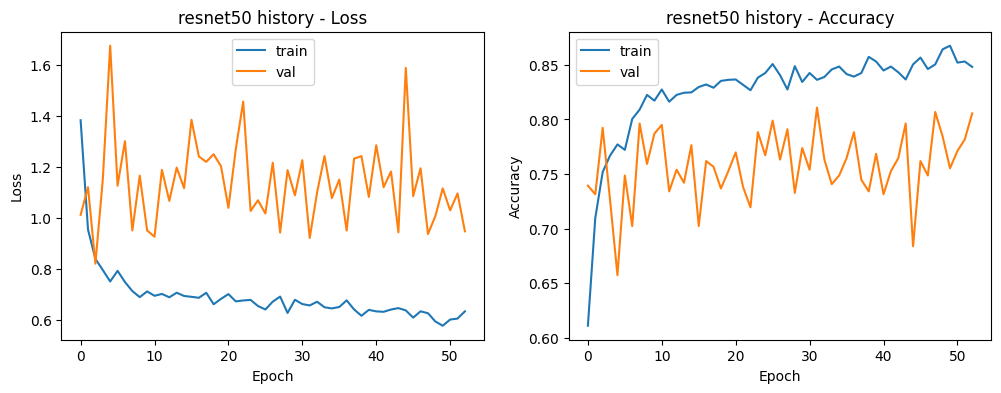


[resnet50] train metrics:
  Acc: 0.8264
  Precision (macro / weighted): 0.8241 / 0.8333
  Recall    (macro / weighted): 0.8365 / 0.8264
  F1        (macro / weighted): 0.8239 / 0.8241
  AUC (macro, OVR): 0.9836


2025-07-26 14:53:59.926378: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


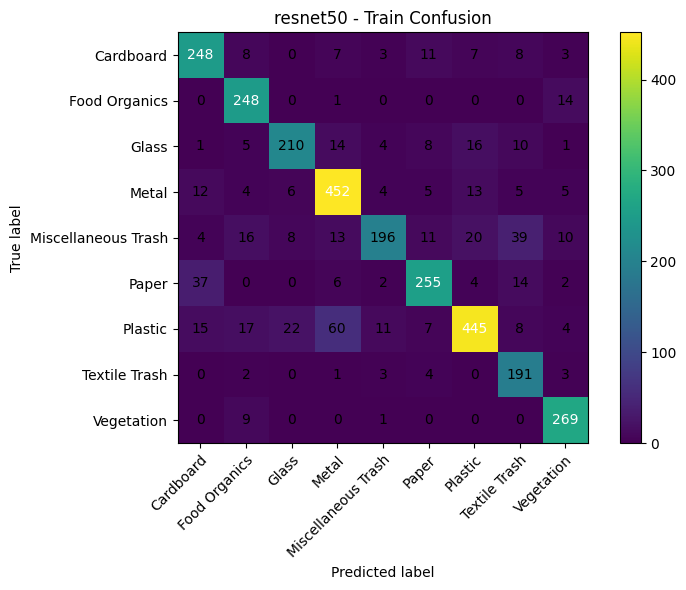


[resnet50] val metrics:
  Acc: 0.7923
  Precision (macro / weighted): 0.7963 / 0.8060
  Recall    (macro / weighted): 0.7989 / 0.7923
  F1        (macro / weighted): 0.7814 / 0.7848
  AUC (macro, OVR): 0.9736


2025-07-26 14:54:13.662853: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


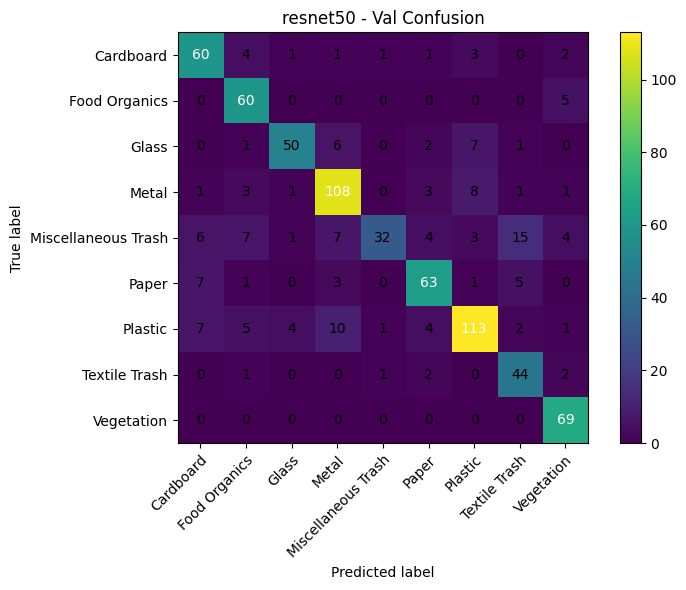


[resnet50] test metrics:
  Acc: 0.7390
  Precision (macro / weighted): 0.7297 / 0.7398
  Recall    (macro / weighted): 0.7387 / 0.7390
  F1        (macro / weighted): 0.7153 / 0.7226
  AUC (macro, OVR): 0.9653


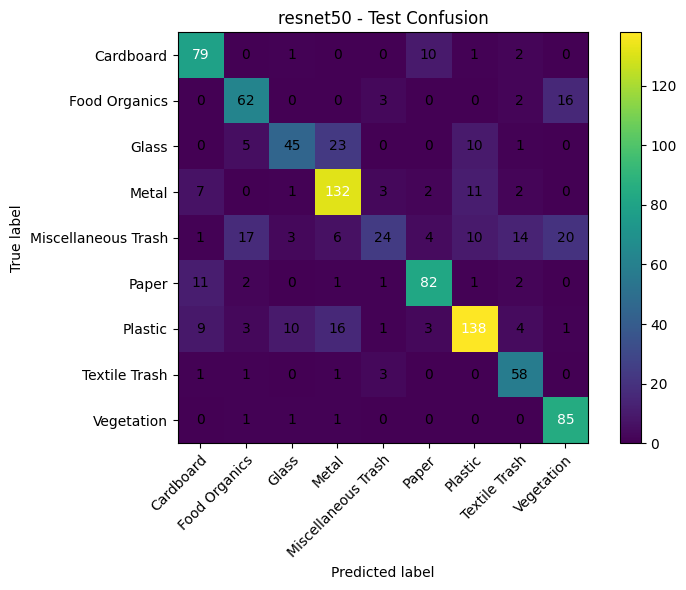


Training backbone: resnet101v2
Epoch 1/100
609/609 - 115s - 188ms/step - accuracy: 0.5690 - loss: 1.5290 - val_accuracy: 0.7037 - val_loss: 1.1460
Epoch 2/100
609/609 - 111s - 183ms/step - accuracy: 0.6644 - loss: 1.1155 - val_accuracy: 0.7553 - val_loss: 0.8944
Epoch 3/100
609/609 - 112s - 184ms/step - accuracy: 0.7140 - loss: 0.9331 - val_accuracy: 0.7606 - val_loss: 0.9398
Epoch 4/100
609/609 - 114s - 187ms/step - accuracy: 0.7245 - loss: 0.9111 - val_accuracy: 0.7447 - val_loss: 0.9188
Epoch 5/100
609/609 - 123s - 202ms/step - accuracy: 0.7245 - loss: 0.9294 - val_accuracy: 0.7540 - val_loss: 0.9300
Epoch 6/100
609/609 - 115s - 189ms/step - accuracy: 0.7538 - loss: 0.8584 - val_accuracy: 0.7262 - val_loss: 1.1615
Epoch 7/100
609/609 - 112s - 184ms/step - accuracy: 0.7439 - loss: 0.8988 - val_accuracy: 0.7368 - val_loss: 1.0449
Epoch 8/100
609/609 - 98s - 161ms/step - accuracy: 0.7505 - loss: 0.8910 - val_accuracy: 0.7315 - val_loss: 1.0119
Epoch 9/100
609/609 - 115s - 189ms/step -

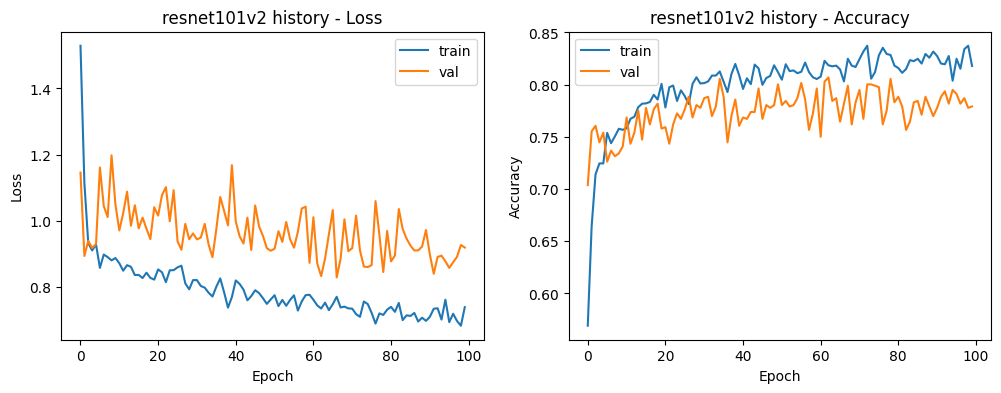


[resnet101v2] train metrics:
  Acc: 0.8738
  Precision (macro / weighted): 0.8790 / 0.8779
  Recall    (macro / weighted): 0.8842 / 0.8738
  F1        (macro / weighted): 0.8785 / 0.8723
  AUC (macro, OVR): 0.9918


2025-07-26 17:43:12.256507: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


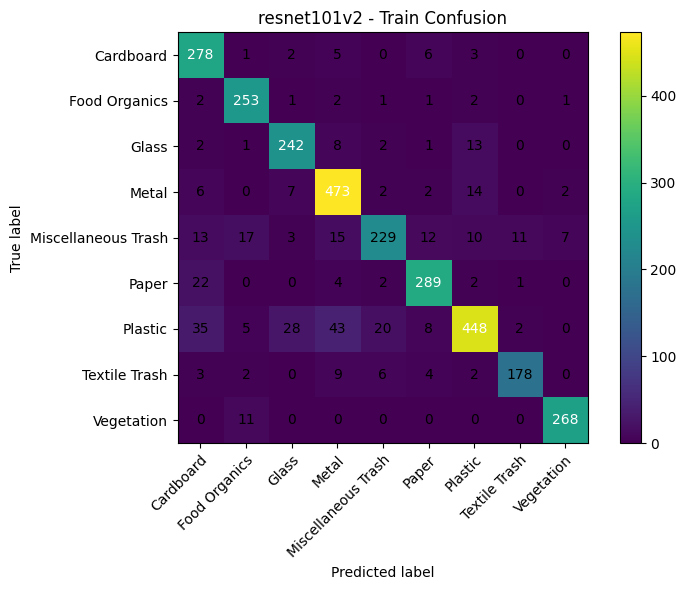


[resnet101v2] val metrics:
  Acc: 0.7817
  Precision (macro / weighted): 0.7831 / 0.7895
  Recall    (macro / weighted): 0.7837 / 0.7817
  F1        (macro / weighted): 0.7777 / 0.7797
  AUC (macro, OVR): 0.9777


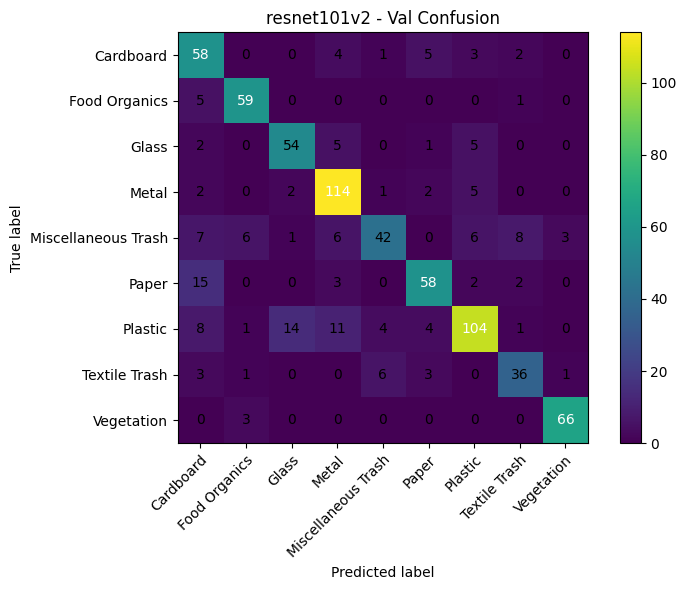


[resnet101v2] test metrics:
  Acc: 0.7338
  Precision (macro / weighted): 0.7258 / 0.7312
  Recall    (macro / weighted): 0.7203 / 0.7338
  F1        (macro / weighted): 0.7138 / 0.7242
  AUC (macro, OVR): 0.9589


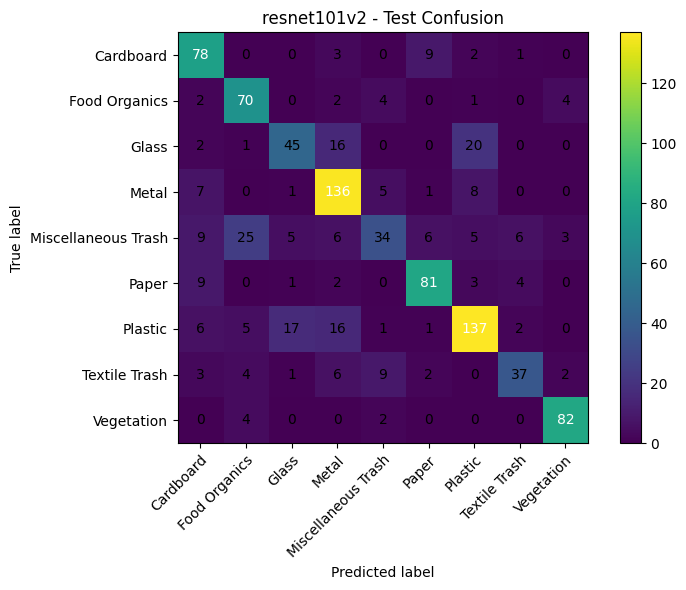


Training backbone: efficientnetb0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
609/609 - 66s - 109ms/step - accuracy: 0.6029 - loss: 1.4336 - val_accuracy: 0.7632 - val_loss: 0.8837
Epoch 2/100
609/609 - 56s - 91ms/step - accuracy: 0.7012 - loss: 0.9783 - val_accuracy: 0.7804 - val_loss: 0.8484
Epoch 3/100
609/609 - 56s - 92ms/step - accuracy: 0.7324 - loss: 0.9089 - val_accuracy: 0.7685 - val_loss: 0.8364
Epoch 4/100
609/609 - 57s - 93ms/step - accuracy: 0.7590 - loss: 0.8656 - val_accuracy: 0.7937 - val_loss: 0.7970
Epoch 5/100
609/609 - 61s - 100ms/step - accuracy: 0.7600 - loss: 0.8423 - val_accuracy: 0.8003 - val_loss: 0.7706
Epoch 6/100
609/609 - 53s - 88ms/step - accuracy: 0.7748 - loss: 0.8190 - val_accuracy: 0.7672 - val_loss: 0.9180
Epoch 7/100
609/609 - 58s - 96ms/step - accuracy: 0.7821 - loss: 0.7953 - val_accuracy: 0.7804 - val_loss: 0.8633
Epoch 8/100
609/609 - 61s - 100ms/step - accuracy: 0.7771 - loss: 0.8123 - val_accuracy: 0.8122 - val_loss: 0.7389

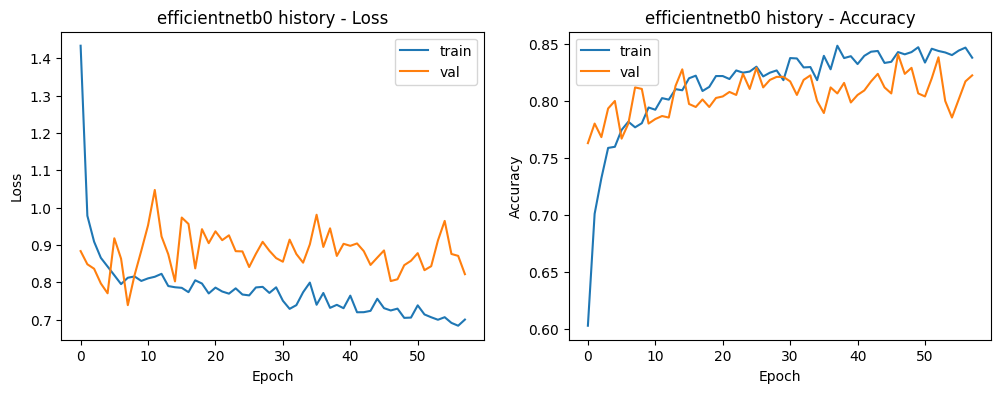


[efficientnetb0] train metrics:
  Acc: 0.8623
  Precision (macro / weighted): 0.8680 / 0.8692
  Recall    (macro / weighted): 0.8714 / 0.8623
  F1        (macro / weighted): 0.8639 / 0.8604
  AUC (macro, OVR): 0.9893


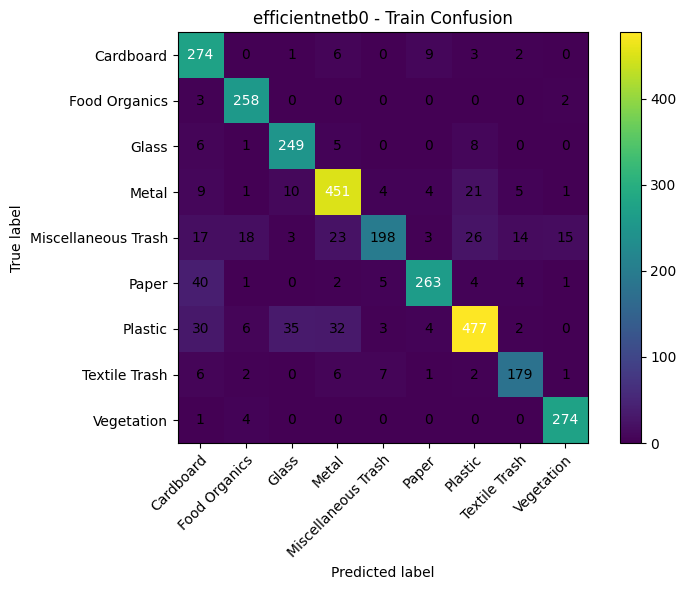


[efficientnetb0] val metrics:
  Acc: 0.8122
  Precision (macro / weighted): 0.8086 / 0.8154
  Recall    (macro / weighted): 0.8167 / 0.8122
  F1        (macro / weighted): 0.8084 / 0.8098
  AUC (macro, OVR): 0.9817


2025-07-26 18:43:05.445307: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


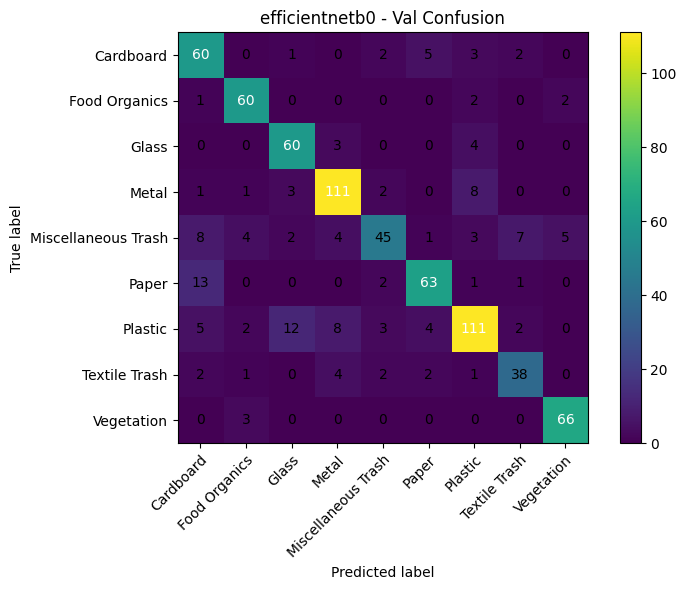


[efficientnetb0] test metrics:
  Acc: 0.7212
  Precision (macro / weighted): 0.7069 / 0.7160
  Recall    (macro / weighted): 0.7203 / 0.7212
  F1        (macro / weighted): 0.7002 / 0.7066
  AUC (macro, OVR): 0.9532


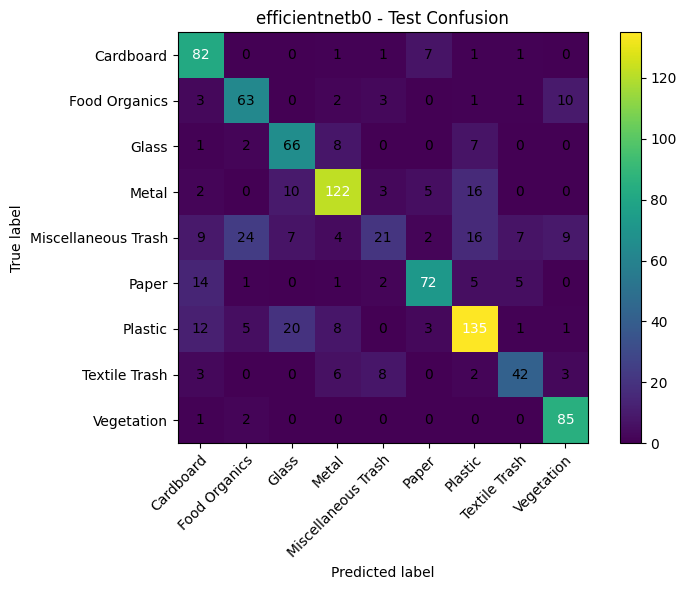


Training backbone: vgg16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
609/609 - 97s - 159ms/step - accuracy: 0.5473 - loss: 1.5210 - val_accuracy: 0.6653 - val_loss: 1.2964
Epoch 2/100
609/609 - 104s - 171ms/step - accuracy: 0.6397 - loss: 1.1083 - val_accuracy: 0.7037 - val_loss: 1.1690
Epoch 3/100
609/609 - 84s - 139ms/step - accuracy: 0.6815 - loss: 1.0267 - val_accuracy: 0.6098 - val_loss: 1.7072
Epoch 4/100
609/609 - 84s - 138ms/step - accuracy: 0.6818 - loss: 0.9881 - val_accuracy: 0.7447 - val_loss: 0.9563
Epoch 5/100
609/609 - 82s - 135ms/step - accuracy: 0.7074 - loss: 0.9438 - val_accuracy: 0.7183 - val_loss: 1.1297
Epoch 6/100
609/609 - 86s - 142ms/step - accuracy: 0.7005 - loss: 0.9544 - val_accuracy: 0.7235 - val_loss: 1.0211
Epoch 7/100
609/609 - 86s - 141ms/step - accuracy: 0.7170 - loss: 0.9256 - val_accuracy: 0.7460 - val_loss: 1.0540
Epoch 8/100
609/609 - 84s - 138ms/step - accuracy: 0.7124 - loss: 0.9390 - val_accuracy: 0.7275 - val_loss: 1.0202
Ep

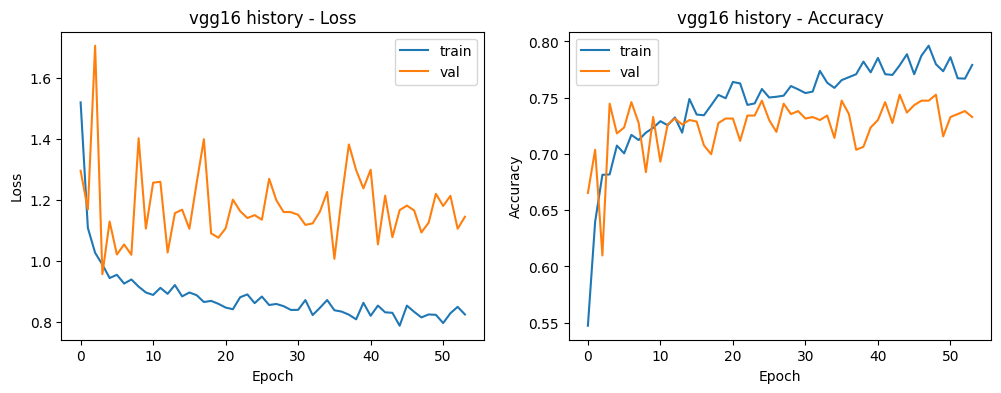


[vgg16] train metrics:
  Acc: 0.7886
  Precision (macro / weighted): 0.8033 / 0.7962
  Recall    (macro / weighted): 0.7913 / 0.7886
  F1        (macro / weighted): 0.7904 / 0.7861
  AUC (macro, OVR): 0.9743


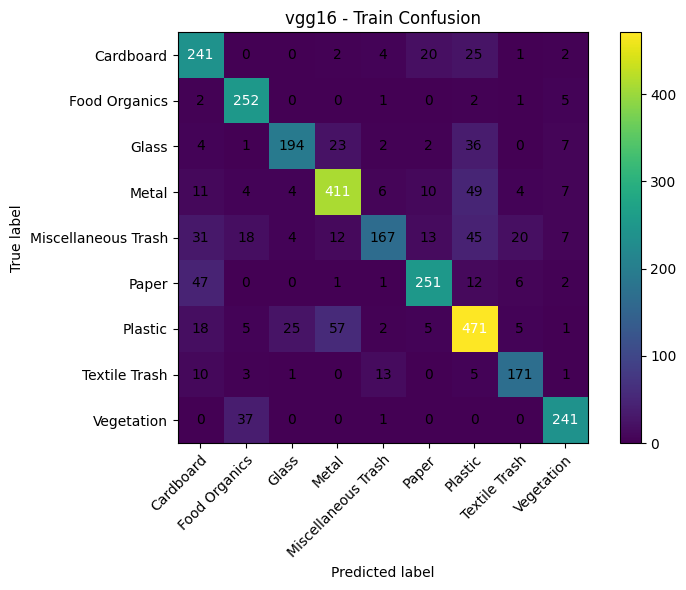


[vgg16] val metrics:
  Acc: 0.7447
  Precision (macro / weighted): 0.7565 / 0.7544
  Recall    (macro / weighted): 0.7474 / 0.7447
  F1        (macro / weighted): 0.7413 / 0.7398
  AUC (macro, OVR): 0.9598


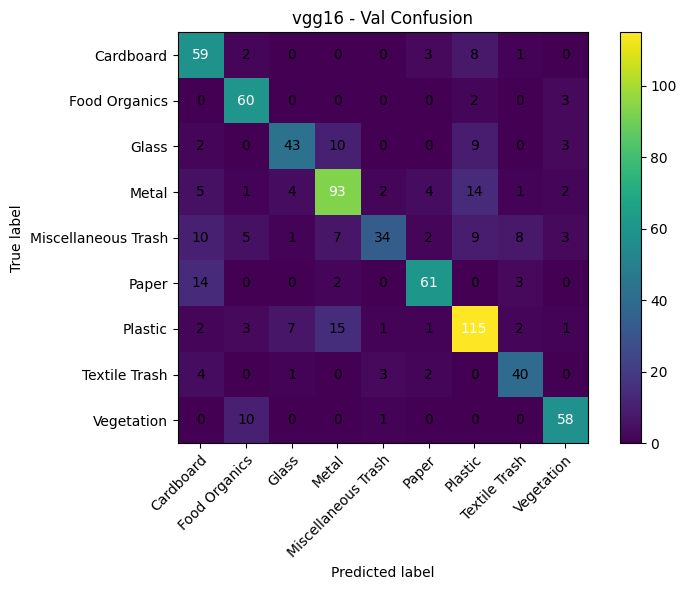


[vgg16] test metrics:
  Acc: 0.6792
  Precision (macro / weighted): 0.6633 / 0.6694
  Recall    (macro / weighted): 0.6734 / 0.6792
  F1        (macro / weighted): 0.6581 / 0.6654
  AUC (macro, OVR): 0.9461


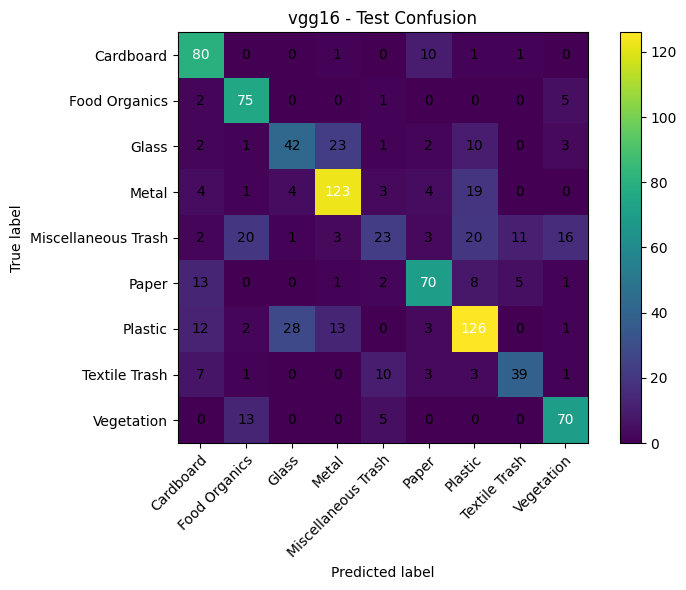

,backbone,split,accuracy,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,auc_macro
0,resnet50,train,0.826430,0.824148,0.836524,0.823854,0.833281,0.826430,0.824068,0.983601
1,resnet50,val,0.792328,0.796324,0.798853,0.781398,0.805964,0.792328,0.784830,0.973568
2,resnet50,test,0.738994,0.729725,0.738682,0.715325,0.739796,0.738994,0.722584,0.965332
3,resnet101v2,train,0.873767,0.878950,0.884224,0.878466,0.877854,0.873767,0.872314,0.991811
4,resnet101v2,val,0.781746,0.783087,0.783733,0.777654,0.789548,0.781746,0.779733,0.977694
5,resnet101v2,test,0.733753,0.725826,0.720275,0.713809,0.731246,0.733753,0.724209,0.958875
6,efficientnetb0,train,0.862262,0.868018,0.871402,0.863946,0.869235,0.862262,0.860378,0.989349
7,efficientnetb0,val,0.812169,0.808565,0.816690,0.808370,0.815435,0.812169,0.809787,0.981666
8,efficientnetb0,test,0.721174,0.706863,0.720293,0.700241,0.716035,0.721174,0.706618,0.953210
9,vgg16,train,0.788626,0.803273,0.791272,0.790409,0.796187,0.788626,0.786123,0.974305


In [11]:
all_results = []

for backbone in BACKBONES:
    print("\n" + "="*80)
    print(f"Training backbone: {backbone}")
    print("="*80)

    model, history, ckpt_path = train_one_model(backbone)

    # training
    ytr_true, ytr_pred, ytr_prob, ytr_onehot = collect_preds(model, train_ds)
    res_train = metrics_report(backbone, "train", ytr_true, ytr_pred, ytr_prob, ytr_onehot)
    show_confusion(ytr_true, ytr_pred, classes, title=f"{backbone} - Train Confusion")

    # validation
    yv_true, yv_pred, yv_prob, yv_onehot = collect_preds(model, val_ds)
    res_val = metrics_report(backbone, "val", yv_true, yv_pred, yv_prob, yv_onehot)
    show_confusion(yv_true, yv_pred, classes, title=f"{backbone} - Val Confusion")

    # testing
    yte_true, yte_pred, yte_prob, yte_onehot = collect_preds(model, test_ds)
    res_test = metrics_report(backbone, "test", yte_true, yte_pred, yte_prob, yte_onehot)
    show_confusion(yte_true, yte_pred, classes, title=f"{backbone} - Test Confusion")

    all_results.extend([res_train, res_val, res_test])

results_df = pd.DataFrame(all_results)
results_df

### Results

In [12]:
summary = results_df.pivot_table(
    index="backbone", columns="split",
    values=["accuracy", "precision_macro", "recall_macro", "f1_macro", "auc_macro"]
)
summary = summary.sort_values(("f1_macro", "test"), ascending=False)
print(summary.round(4))

best_model = summary.index[0]
best_f1 = summary.loc[best_model, ("f1_macro", "test")]
print(f"\nBest (by test F1_macro): {best_model} @ {best_f1:.4f}")

               accuracy                 auc_macro                 f1_macro  \
split              test   train     val      test   train     val     test   
backbone                                                                     
resnet50         0.7390  0.8264  0.7923    0.9653  0.9836  0.9736   0.7153   
resnet101v2      0.7338  0.8738  0.7817    0.9589  0.9918  0.9777   0.7138   
efficientnetb0   0.7212  0.8623  0.8122    0.9532  0.9893  0.9817   0.7002   
vgg16            0.6792  0.7886  0.7447    0.9461  0.9743  0.9598   0.6581   

                               precision_macro                 recall_macro  \
split            train     val            test   train     val         test   
backbone                                                                      
resnet50        0.8239  0.7814          0.7297  0.8241  0.7963       0.7387   
resnet101v2     0.8785  0.7777          0.7258  0.8790  0.7831       0.7203   
efficientnetb0  0.8639  0.8084          0.7069  0.8680  0.

### Detailed classification reports

In [15]:
def print_cls_report(name, y_true_ids, y_pred):
    print(f"\nClassification report: {name}")
    print(classification_report(y_true_ids, y_pred, target_names=classes, zero_division=0))

def custom_objects_for(backbone):
    return {"preprocess_input": PREPROCESSORS[backbone]}

for backbone in BACKBONES:
    ckpt = checkpoint_dir / f"{backbone}_best.keras"
    if not ckpt.exists():
        print(f"[WARN] Checkpoint not found for {backbone}: {ckpt}. Skipping.")
        continue

    m = tf.keras.models.load_model(ckpt, compile=False, custom_objects=custom_objects_for(backbone))

    ytr_true, ytr_pred, *_ = collect_preds(m, train_ds)
    print_cls_report(f"{backbone} - Train", ytr_true, ytr_pred)

    yv_true, yv_pred, *_ = collect_preds(m, val_ds)
    print_cls_report(f"{backbone} - Val", yv_true, yv_pred)

    yte_true, yte_pred, *_ = collect_preds(m, test_ds)
    print_cls_report(f"{backbone} - Test", yte_true, yte_pred)

    del m
    tf.keras.backend.clear_session()


Classification report: resnet50 - Train
                     precision    recall  f1-score   support

          Cardboard       0.78      0.84      0.81       295
      Food Organics       0.80      0.94      0.87       263
              Glass       0.85      0.78      0.82       269
              Metal       0.82      0.89      0.85       506
Miscellaneous Trash       0.88      0.62      0.72       317
              Paper       0.85      0.80      0.82       320
            Plastic       0.88      0.76      0.81       589
      Textile Trash       0.69      0.94      0.80       204
         Vegetation       0.86      0.96      0.91       279

           accuracy                           0.83      3042
          macro avg       0.82      0.84      0.82      3042
       weighted avg       0.83      0.83      0.82      3042


Classification report: resnet50 - Val
                     precision    recall  f1-score   support

          Cardboard       0.74      0.82      0.78        73
 

2025-07-26 20:41:42.277351: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification report: resnet101v2 - Train
                     precision    recall  f1-score   support

          Cardboard       0.77      0.94      0.85       295
      Food Organics       0.87      0.96      0.92       263
              Glass       0.86      0.90      0.88       269
              Metal       0.85      0.93      0.89       506
Miscellaneous Trash       0.87      0.72      0.79       317
              Paper       0.89      0.90      0.90       320
            Plastic       0.91      0.76      0.83       589
      Textile Trash       0.93      0.87      0.90       204
         Vegetation       0.96      0.96      0.96       279

           accuracy                           0.87      3042
          macro avg       0.88      0.88      0.88      3042
       weighted avg       0.88      0.87      0.87      3042


Classification report: resnet101v2 - Val
                     precision    recall  f1-score   support

          Cardboard       0.58      0.79      0.67      

In [16]:
def macro_auc_ovr(y_true_onehot, y_prob):
    try:
        return roc_auc_score(y_true_onehot, y_prob, multi_class="ovr", average="macro")
    except Exception:
        return float("nan")

auc_train = macro_auc_ovr(ytr_onehot, ytr_prob)
auc_val = macro_auc_ovr(yv_onehot, yv_prob)
auc_test = macro_auc_ovr(yte_onehot, yte_prob)

print(f"AUC macro OVR -> train: {auc_train:.4f}, val: {auc_val:.4f}, test: {auc_test:.4f}")

AUC macro OVR -> train: 0.9743, val: 0.9598, test: 0.9461


### Final Thoughts and Observations

We trained four transfer‑learning classifiers—ResNet50, ResNet101V2, EfficientNetB0, and VGG16—freezing all backbone layers and training a ReLU‑BN‑Dropout(0.2) head with L2 regularization, using Adam and categorical cross‑entropy. 

We applied augmentation (flip, rotation, zoom, translation, contrast, random crop) and early stopping on a per‑class 20% validation split. Across models, macro AUC (OVR) was high (≈0.95 on validation and ≈0.95 on test for the reported model), indicating good ranking performance. 

On the held‑out test set, ResNet50 achieved the best macro F1 (≈0.72) and accuracy (≈0.74), narrowly outperforming ResNet101V2 and EfficientNetB0. EfficientNetB0 led on validation, and ResNet101V2 was strongest on training, but ResNet50 generalized best to the test data. 

Performance was consistently strong for classes like Vegetation, whereas Miscellaneous Trash remained challenging due to intra‑class variability.